# **MicNet pipeline**
Micnet is a package developed for the analysis of microbial abundance table. It proposes an analysis pipeline which consists of three modules:
1. Visualization with UMAP and HDBSCAN
2. Estimation of the co-ocurrence network between species or OTUS with an enhanced version of SparCC.
3. Estimation of several graph theory metrics to describe the topology of the resulting network.

In this notebook we show an implementation of the analysis pipeline for the Komnbucha dataset described in (Arikan et al 2020)[https://ift.onlinelibrary.wiley.com/doi/full/10.1111/1750-3841.14992]. 

For more information about the Micnet package: (Favila, Madrigal-Trejo et al 2021)[https://www.biorxiv.org/content/10.1101/2021.11.11.468289v1.full.pdf].

If you prefer to use a GUI to implement most of the code presented here you can try our web app at: (web dashboard)[http://micnetapplb-1212130533.us-east-1.elb.amazonaws.com/]. And you can run this web app in your computer deploying the GUI locally with the code specified in our (github repository)[https://github.com/Labevo/MicNetToolbox].

## **Packages and dependancies**
### If you have not install the micnet package yet, please run the following code and remember to always create and activate teh MicNet-env first:

In [1]:
pip install micnet==1.0.0

  Attempting uninstall: micnet
    Found existing installation: micnet 0.0.154
    Uninstalling micnet-0.0.154:
      Successfully uninstalled micnet-0.0.154
Note: you may need to restart the kernel to use updated packages.


### Now we can import the packages we need to run the complete analysis pipeline

In [35]:
import hdbscan
import micnet as mc
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import show
from bokeh.io import output_notebook
# Call once to configure Bokeh to display plots inline in the notebook.
output_notebook()

Loading BokehJS ...

## **1.** **Load Kombucha data**

Now we will load and inspect the Kombucha data from the MicNet package. We can see that the data consist of 179 OTUs in the rows and in the columns we have the ASV id, the taxa classification and the abundance of 11 samples. 

In [5]:
data = mc.load_kombucha()
print(data.shape)
data.head()

(179, 14)


,ASV_P,Taxa,ERR2139368,ERR2139369,ERR2139370,ERR2139371,ERR2139372,ERR2139373,ERR2139374,ERR2139375,ERR2139376,ERR2139377,ERR2139378,ERR2139379
0,ASV_P_1,Bacteria;Proteobacteria;Alphaproteobacteria;Ac...,3372.0,225.0,558.0,1405.0,256.0,3022.0,5302.0,3629.0,5569.0,3376.0,3690.0,4762.0
1,ASV_P_2,Bacteria;Proteobacteria;Alphaproteobacteria;Ac...,2373.0,705.0,530.0,3661.0,180.0,2229.0,3582.0,3670.0,4164.0,2559.0,2954.0,3090.0
2,ASV_P_3,Bacteria;Proteobacteria;Alphaproteobacteria;Ac...,2364.0,804.0,572.0,596.0,621.0,2741.0,4037.0,3156.0,4136.0,2842.0,3418.0,4230.0
3,ASV_P_4,Bacteria;Proteobacteria;Alphaproteobacteria;Ac...,2231.0,657.0,1954.0,4031.0,762.0,1799.0,743.0,848.0,3475.0,2142.0,2181.0,2290.0
4,ASV_P_5,Bacteria;Proteobacteria;Alphaproteobacteria;Ac...,1997.0,919.0,2215.0,2580.0,145.0,1348.0,2551.0,2482.0,3393.0,626.0,281.0,483.0


## **1.1 Pre-processing the data**
We have the option of filtering out singletons and low-abundace OTUs.In this case we will do it to have a more reliable dataset to work with.

In [6]:
# the filtering functions needs you to specify if the input data contains any taxa information
from micnet.utils import filter_otus
X,Taxa,Text = filter_otus(data,taxa=True,low_abundance=True)
print(X.shape)
X

(48, 12)


,ERR2139368,ERR2139369,ERR2139370,ERR2139371,ERR2139372,ERR2139373,ERR2139374,ERR2139375,ERR2139376,ERR2139377,ERR2139378,ERR2139379
0,3372.0,225.0,558.0,1405.0,256.0,3022.0,5302.0,3629.0,5569.0,3376.0,3690.0,4762.0
1,2373.0,705.0,530.0,3661.0,180.0,2229.0,3582.0,3670.0,4164.0,2559.0,2954.0,3090.0
2,2364.0,804.0,572.0,596.0,621.0,2741.0,4037.0,3156.0,4136.0,2842.0,3418.0,4230.0
3,2231.0,657.0,1954.0,4031.0,762.0,1799.0,743.0,848.0,3475.0,2142.0,2181.0,2290.0
4,1997.0,919.0,2215.0,2580.0,145.0,1348.0,2551.0,2482.0,3393.0,626.0,281.0,483.0
5,2162.0,662.0,1672.0,2657.0,2793.0,1020.0,202.0,2541.0,327.0,988.0,2395.0,113.0
6,3071.0,1981.0,2482.0,383.0,3595.0,1450.0,286.0,569.0,266.0,384.0,1781.0,568.0
7,2183.0,548.0,446.0,3100.0,1590.0,289.0,905.0,2600.0,1178.0,945.0,1971.0,282.0
8,709.0,859.0,2782.0,456.0,680.0,941.0,1142.0,733.0,1466.0,867.0,1183.0,1482.0
9,1477.0,196.0,1426.0,540.0,312.0,1026.0,2237.0,437.0,2284.0,1105.0,340.0,1866.0


## **2. Visualize the data with UMAP and HDBSCAN**

To visualize our abundance table using dimension reduction technique UMAP and HDBSCAN for clustering we need to create a class called **Embedding_Ouput**. This is where we have to decide on the parameters of umap and hdbscan. For the Kombucha example we will set them as in the paper by Favila et al (2021).

In [7]:
#Set parameter values
#The metrisc for umap and hdbscan can be picked from the following:
METRIC_UMAP=['euclidean','manhattan','canberra','braycurtis', 'cosine','correlation','hellinger']
METRIC_HDB=['euclidean','manhattan','canberra','braycurtis']
n_neighbors = 2
min_dist = 1
n_components = 2 
metric_umap = METRIC_UMAP[0]
metric_hdb = METRIC_HDB[0]
min_cluster_size = 2
min_sample = 3

embedding_outliers=mc.Embedding_Output(n_neighbors=n_neighbors,min_dist=min_dist, n_components=n_components,
                                    metric_umap=metric_umap,metric_hdb=metric_hdb,min_cluster_size=min_cluster_size,
                                    min_sample=min_sample,output=True)

Now we the object created we can obtained the two dimensions from the UMAP reduction analysis and then we proceed to plot it in a ciruclar arrangement.

In [8]:
embedding,o,l=embedding_outliers.fit(X)

C:\Users\natal\anaconda3\envs\MicNet-env\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [9]:
mc.plot_umap(embedding,l,Text,Taxa)

To have all the data of which OTU belongs to which cluster and if it is an outlier or not we can put all teh data together in a dataframe:

In [10]:
DF=pd.DataFrame()
if len(Taxa)>1:
    DF['Taxa']= Text.iloc[:,1]
DF['Outliers']=o
DF['Cluster']=l
DF.head()

,Taxa,Outliers,Cluster
0,Bacteria;Proteobacteria;Alphaproteobacteria;Ac...,0,0
1,Bacteria;Proteobacteria;Alphaproteobacteria;Ac...,0,0
2,Bacteria;Proteobacteria;Alphaproteobacteria;Ac...,1,0
3,Bacteria;Proteobacteria;Alphaproteobacteria;Ac...,0,0
4,Bacteria;Proteobacteria;Alphaproteobacteria;Ac...,0,0


## **3. SparCC: calculating co-occurrence network**

To run SparCC on our abundace table we first need to instatiate the class SparCC_MicNet with the values of the parameters that we wish Sparcc is run with as follows:


In [11]:
#SparCC is run wihtout any ASV or taxa so we first clean our dataset
dataSparcc = data.iloc[:,2:]
print(dataSparcc.shape)
dataSparcc.head()

(179, 12)


,ERR2139368,ERR2139369,ERR2139370,ERR2139371,ERR2139372,ERR2139373,ERR2139374,ERR2139375,ERR2139376,ERR2139377,ERR2139378,ERR2139379
0,3372.0,225.0,558.0,1405.0,256.0,3022.0,5302.0,3629.0,5569.0,3376.0,3690.0,4762.0
1,2373.0,705.0,530.0,3661.0,180.0,2229.0,3582.0,3670.0,4164.0,2559.0,2954.0,3090.0
2,2364.0,804.0,572.0,596.0,621.0,2741.0,4037.0,3156.0,4136.0,2842.0,3418.0,4230.0
3,2231.0,657.0,1954.0,4031.0,762.0,1799.0,743.0,848.0,3475.0,2142.0,2181.0,2290.0
4,1997.0,919.0,2215.0,2580.0,145.0,1348.0,2551.0,2482.0,3393.0,626.0,281.0,483.0


In [12]:
# set parameters for SparCC
n_iteractions=3
x_iteractions=3
low_abundance=True
threshold=0.1
normalization='dirichlet'
log_transform=True
num_simulate_data=5
type_pvalues='one_sided'

#Create Sparcc object
SparCC_MN = mc.SparCC_MicNet(n_iteractions=n_iteractions,
                                    x_iteractions=x_iteractions,
                                    low_abundance=low_abundance,
                                    threshold=threshold,
                                    normalization=normalization,
                                    log_transform=log_transform,
                                    num_simulate_data=num_simulate_data,
                                    type_pvalues=type_pvalues,
                                    )

Then we actually run the sparcc algorithm with the method run_all

In [13]:
SparCC_MN.run_all(data_input=dataSparcc)


Finished parsing table.
Table dimensions, num_rows: 12 & num_colums: 48
**** Data has been transposed! ****
	Running iteration 0
	Running iteration 1
	Running iteration 2
Shape of Correlation Matrix: (48, 48)
Shape of Covariance Matrix: (48, 48)

Finished parsing table.
Table dimensions, num_rows: 12 & num_colums: 48
**** Data has been transposed! ****
Permutations
####################################################################################################
Iteration: 0
Error: ./temp_files/*:El proceso no tiene acceso al archivo porque está siendo utilizado por otro proceso

Finished parsing table.
Table dimensions, num_rows: 12 & num_colums: 48
**** Data has been transposed! ****
	Running iteration 0


C:\Users\natal\anaconda3\envs\MicNet-env\lib\site-packages\micnet\sparcc\core\SparCC.py:204: UserWarning: Sparcity assumption violated. Returning clr result.
  warnings.warn('Sparcity assumption violated. Returning clr result.')
C:\Users\natal\anaconda3\envs\MicNet-env\lib\site-packages\micnet\sparcc\core\SparCC.py:204: UserWarning: Sparcity assumption violated. Returning clr result.
  warnings.warn('Sparcity assumption violated. Returning clr result.')
C:\Users\natal\anaconda3\envs\MicNet-env\lib\site-packages\micnet\sparcc\core\SparCC.py:204: UserWarning: Sparcity assumption violated. Returning clr result.
  warnings.warn('Sparcity assumption violated. Returning clr result.')


	Running iteration 1
	Running iteration 2
Shape of Correlation Matrix: (48, 48)
Shape of Covariance Matrix: (48, 48)
####################################################################################################
Iteration: 1
Error: ./temp_files/*:El proceso no tiene acceso al archivo porque está siendo utilizado por otro proceso

Finished parsing table.
Table dimensions, num_rows: 12 & num_colums: 48
**** Data has been transposed! ****
	Running iteration 0
	Running iteration 1
	Running iteration 2
Shape of Correlation Matrix: (48, 48)
Shape of Covariance Matrix: (48, 48)
####################################################################################################
Iteration: 2
Error: ./temp_files/*:El proceso no tiene acceso al archivo porque está siendo utilizado por otro proceso

Finished parsing table.
Table dimensions, num_rows: 12 & num_colums: 48
**** Data has been transposed! ****
	Running iteration 0
	Running iteration 1
	Running iteration 2
Shape of Correlation Mat

sparcc will compute the correlations and the pvalues separately:

In [14]:
DF_SparCC=pd.read_csv(Path(SparCC_MN.save_corr_file).resolve(),index_col=0)
DF_PValues=pd.read_csv(Path(SparCC_MN.outfile_pvals).resolve(),index_col=0)

So we can obtain the final significant correlations found by filtering them out by their p-value:

In [15]:
sparcc_corr=DF_SparCC[DF_PValues<0.05].fillna(0)
print(f'The resulting corellation matrix is of size {sparcc_corr.shape}')
sparcc_corr.head() 

The resulting corellation matrix is of size (48, 48)


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.000000,0.942259,0.924679,0.645109,0.482555,-0.221567,0.00000,0.000000,0.521251,0.763563,...,0.0,0.000000,0.000000,-0.199495,0.000000,-0.425005,0.632308,0.409914,0.000000,0.000000
1,0.942259,0.000000,0.810159,0.629160,0.520505,0.000000,-0.29354,0.000000,0.399637,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,-0.476376,0.564475,0.392524,0.000000,0.000000
2,0.924679,0.810159,0.000000,0.000000,0.000000,-0.279318,0.00000,0.000000,0.633546,0.000000,...,0.0,0.000000,-0.284106,-0.165375,0.257643,-0.497348,0.739666,0.000000,0.069052,0.000000
3,0.645109,0.629160,0.000000,0.000000,0.329027,0.000000,0.00000,0.252111,0.682573,0.713621,...,0.0,0.000000,0.000000,-0.480161,0.000000,-0.480070,0.796863,0.000000,0.514467,0.000000
4,0.482555,0.520505,0.000000,0.329027,0.000000,-0.454494,0.00000,0.000000,0.000000,0.577679,...,0.0,0.320746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.630576,0.384317


## **4.Network analysis**

The final step on the proposed analysis pipeline of MicNet is to obtain large scale metrics of the network and subgroups based on their relationships. 

To do this we begin by building the graph of the matrix obtained from SparCC to be able to get large-scale metrics. Note that we can do this in two ways, by normalizing the correlation values to a range of (0,1) or we can leave the values as they are, this is your decision, but note that some graph theory analysis only work with normalized values.

In [16]:
M = mc.build_network(sparcc_corr)
Mnorm = mc.build_normalize_network(sparcc_corr)

Now we can create a network micnet obejct which we will use to obtain most of our descriptors and analysis of the network

In [17]:
NetM=mc.NetWork_MicNet()

Les start by looking at some of the basic properties of the network, such as number of nodes, number of interactions, diameter, etc..

In [18]:
NetM.basic_description(corr=sparcc_corr)

,Basic network information
Nodes,48.000000
Total interactions,506.000000
Positive interactions,271.000000
Negative interactions,235.000000
Pos-Neg ratio,1.153191
Density,0.447695
Average degree,21.041667
Degree std,5.098849
Components,1.000000
Diameter,3.000000


Now we might be interested in how many triads including different types (such as  + + + or - + -) of interactions are present ir our network. We can do this by calling the structural balance method:

In [19]:
NetM.structural_balance(M)

,Structural balance information
Percentage balanced,0.933962
Percentage unbalanced,0.066038
Triangles +++,0.408805
Triangles --+,0.525157
Triangles ++-,0.062893
Triangles ---,0.003145


Remember that structural balance anaylsis needs the raw data (ranging from -1 to 1), not the normalized ones, that is why in this analysis we used the network M.

Now we can obtain the communties found in the network based on the Louvain method (which finds clusters based on increasing intragroup interactions and minimizing intergroup interactions)

In [20]:
Communities=NetM.community_analysis(Mnorm)

Within the communities object we can extract the number of comminities and a table with a summary of properties of each community found as we show below:

In [21]:
print(Communities['Number'])
print(Communities['Community_topology'])

4
                        Community_0  Community_1  Community_2  Community_3
Nodes                     18.000000    18.000000     4.000000     8.000000
Edges                    107.000000    84.000000     4.000000    23.000000
Density                    0.699346     0.549020     0.666667     0.821429
Average degree            11.888889     9.333333     2.000000     5.750000
degree std                 2.354402     2.808717     0.000000     0.968246
Clustering coefficient     0.735771     0.653155     0.000000     0.811310


Finally, it is also possible to extract the assignement of each node to the different communities found:

In [22]:
print(Communities['Data'].head())

   Community_id
0             0
1             0
2             0
3             0
4             0


Now we obtain the centrlities of the nodes:

In [23]:
Centrality=NetM.key_otus(Mnorm)

For easier display we can put everything in a single database, including the info that we previously obtained from  hdbscan clustering:

In [24]:
NetDF=pd.DataFrame({'OTUS':Centrality['NUM_OTUS'],
              'Degree_Centrality':Centrality['Degree centrality'],
              'Betweeness_Centrality':Centrality['Betweeness centrality'],
              'Closeness_Centrality':Centrality['Closeness centrality'],
              'PageRank':Centrality['PageRank'],
              'HDBSCAN':DF['Cluster'],
              'Community':Communities['Data'].values.ravel()})

We now plot the network, coloring by communities:

In [36]:
pl = mc.plot_bokeh(graph=M,frame=NetDF,
              nodes = M.number_of_nodes(),
              max = sparcc_corr.max().max(),
              min = sparcc_corr.min().min(),
              kind_network='spring',
              kind='Community')
show(pl)

We could also colored the nodes according to the groups found with HDBSCAN and in a circular layout:

In [37]:
pl2 = mc.plot_bokeh(graph=M,frame=NetDF,
              nodes = M.number_of_nodes(),
              max = sparcc_corr.max().max(),
              min = sparcc_corr.min().min(),
              kind_network='circular',
              kind='HDBSCAN')
show(pl2)

### 4.1 Topology comparison

MicNet includes the computation of the distribution of several  large-scale metrics under the assumption that the underlying topology is: 1) a random Erdos-Renyi network, built using function nx.erdos_renyi_graph, 2) a small world Watts-Strogatz built using nx.watts_strogatz_graph function, or 3) a scale-free Barabási-Albert network built using nx.barabasi_albert_graph function.

The topology_boostrap function included in the micnet package takes a correlation matrix as input and returns three dataframes with the distribution for several large-scale metrics under the assumption that the network with the same density and average degree but with the defined topologies mentioned.

Now lest run the boostrap with the Kombucha correlation data:


In [27]:
#Run boostrap
df_rand, df_small, df_scale = mc.topology_boostrap(sparcc_corr, n_boot=20)

Note that the larger the values of n_boot (number of simuations for the boostraping), the longer it will take to run.

Now, we plot as an example the distribution of the average shortest path for networks of the same size as the Kombucha example but with a topology that is random (in red), small-world (in green) or scale-free (in blue) and we see where our Kombucha data lies (black line):

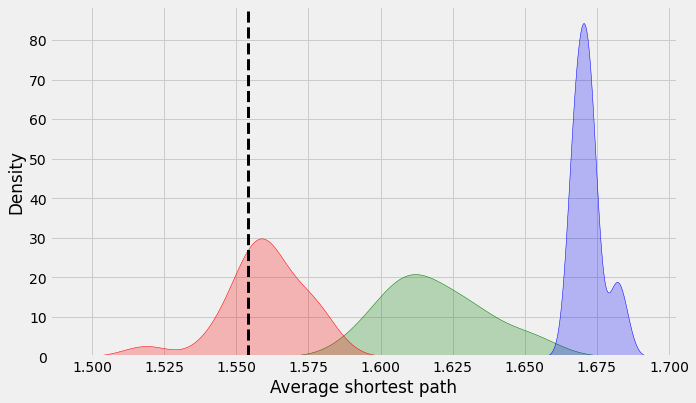

In [28]:
#Plotting average shortest path under the asumption of a random, small-world and scale-free topology.

plt.figure(figsize=(10,6))
sns.kdeplot(df_small['Average shortest path'], color='g', shade=True)
sns.kdeplot(df_rand['Average shortest path'], color='r', shade=True)
sns.kdeplot(df_scale['Average shortest path'], color='b', shade=True)
plt.axvline(1.554078, color = 'black',lw=3, ls = '--')

Degree distributions can also be used to discriminate between network topologies. Thus, we have included in the MicNet toolbox a function that plots the Complementary Cumulative Distribution Function (CCDF) of the degrees of the given network and compares it with the CCDF of a simulated comparable random, scale-free and small-word network on a log-log scale.

To perform the comparison use the following code:

In [29]:
ccdf = mc.degree_comparison(sparcc_corr, topology ='random', bins=20)

the degree_comparison function returns a dataframe with the bins and CCDF for the corr matrix, and the bins and CCDF for an equivalent network with defined topology (which can be specified in the topology parameter as 'random', 'small_world' or scale_free).

We suggest to plot the results as follows:

Text(0, 0.5, 'CCDF')

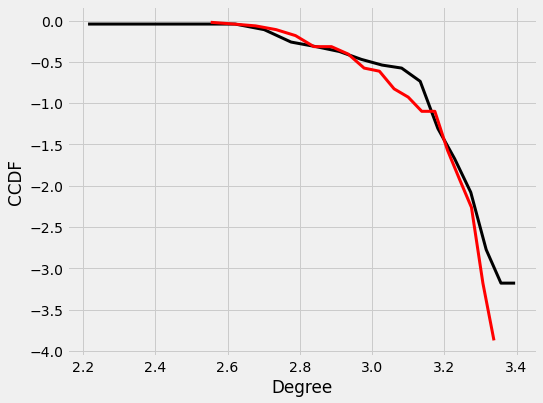

In [30]:
plt.figure(figsize=(7.5,6))
sns.lineplot(x=ccdf.Data_bins,y=ccdf.Data_CCDF, color = 'black',lw= 3)
sns.lineplot(x=ccdf.Simulated_bins,y=ccdf.Simulated_CCDF, color = 'r',lw= 3)
plt.xlabel('Degree')
plt.ylabel('CCDF')

### 4.2 Percolation analysis

The percolation analysis consists of removing nodes and their corresponding edges and analyzing how much the network's properties are disrupted. The percolation simulation consists of n iterations; in each iteration a percentage of the nodes (with default value of 0.1, but this can be specified by the user) is removed along with all of their edges. We have provided two percolations functions to run percolation either by a type of centrality or by defined groups (such as clusters or taxa groups). 

Lets begin by running a percolation by degree centrality. The resulting data will tell us how removing the nodes affected several metrics of the network, such as the number of communities, the modularity, the network's density, amongst others.

In [31]:
#Run percolation removing nodes by degree centrality
percolation = mc.percolation_sim(sparcc_corr, prem =0.1, per_type='deg_centrality')
percolation

,Fraction of removal,Network density,Average degree,Number of components,Size of giant component,Fraction of giant component,Number of communities,Modularity
0,0.083333,0.415433,17.863636,1.0,44.0,1.00,3.0,1.269871e-01
1,0.166667,0.385897,15.050000,1.0,40.0,1.00,4.0,1.816049e-01
2,0.250000,0.361905,12.666667,1.0,36.0,1.00,4.0,1.743082e-01
3,0.333333,0.334677,10.375000,1.0,32.0,1.00,5.0,2.651631e-01
4,0.416667,0.314815,8.500000,1.0,28.0,1.00,5.0,2.359999e-01
5,0.500000,0.304348,7.000000,1.0,24.0,1.00,5.0,2.547196e-01
6,0.583333,0.263158,5.000000,1.0,20.0,1.00,4.0,2.731656e-01
7,0.666667,0.258333,3.875000,1.0,16.0,1.00,4.0,3.261718e-01
8,0.750000,0.242424,2.666667,1.0,12.0,1.00,2.0,3.736097e-01
9,0.833333,0.321429,2.250000,1.0,8.0,1.00,3.0,2.877100e-01


Note tha you can change **prem** (percentage of removal) to modify what percentange of nodes get removed in each iteration, and to modify the type of nodes that are removed first, change **per_type** which can take the values 'random', 'deg_centrality', 'clos_centrality', 'bet_centrality'.

It is also possible to remove the nodes by a list of ids, for example, removing by HDBSCAN groups.

In [32]:
#Run percolation removing nodes by group
grouplist = list(DF['Cluster'])
percolation = mc.percolation_by_group(sparcc_corr, prem=0.1, groups=grouplist)

Note that this analysis will return one table per group and will show how removing each group (in steps of 10%) found in **grouplist** affects the networks properties. So for example if we would want to know what effect would have on the network removing all the elements from group 1 identified by HDBSCAN we would look at the following table

In [33]:
#We first look at all the tables present in the percolation object
print(percolation.keys())

#Now we only see the percolation results from group 1
percolation['Percolation_group_1']

dict_keys(['Percolation_group_0', 'Percolation_group_1', 'Percolation_group_-1'])


,Nodes removed,Network density,Average degree,Number of components,Size of giant component,Fraction of giant component,Number of communities,Modularity
0,3.0,0.444444,19.555556,1.0,45.0,1.0,4.0,0.201619
1,6.0,0.449477,18.428571,1.0,42.0,1.0,3.0,0.191657
2,9.0,0.443995,16.871795,1.0,39.0,1.0,3.0,0.198445
3,12.0,0.455556,15.944444,1.0,36.0,1.0,4.0,0.153940
4,15.0,0.473485,15.151515,1.0,33.0,1.0,3.0,0.163740
5,18.0,0.466667,13.533333,1.0,30.0,1.0,3.0,0.181364
6,21.0,0.492877,12.814815,1.0,27.0,1.0,2.0,0.231836
7,24.0,0.528986,12.166667,1.0,24.0,1.0,2.0,0.147570
8,27.0,0.561905,11.238095,1.0,21.0,1.0,2.0,0.151157
9,30.0,0.562092,9.555556,1.0,18.0,1.0,3.0,0.155186
